In [43]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from transformers import BertTokenizer, LxmertTokenizer
from data import ImageTextClassificationDataset, collate_fn_batch_visualbert, collate_fn_batch_lxmert, collate_fn_batch_visualbert_semi_supervised, collate_fn_batch_lxmert_semi_supervised
from matplotlib import pyplot as plt
import pandas as pd
from functools import partial
import torch
import os
import numpy as np
import cv2 as cv

In [45]:
# import argparse

In [6]:
# parser = argparse.ArgumentParser(description='train')
parser = pd.Series()
parser = parser.append(pd.Series({'img_feature_path': "../data/features/visualgenome/"}))
parser = parser.append(pd.Series({'train_csv_path': "../data/splits/random/memotion_train.csv"}))
parser = parser.append(pd.Series({'val_csv_path': "../data/splits/random/memotion_val.csv"}))
parser = parser.append(pd.Series({'model_type': "visualbert"}))
parser = parser.append(pd.Series({'model_path': "uclanlp/visualbert-vqa-coco-pre"}))
parser = parser.append(pd.Series({'learning_rate': 2e-5}))
parser = parser.append(pd.Series({'epoch': 100}))
parser = parser.append(pd.Series({'eval_step': 100}))
parser = parser.append(pd.Series({'batch_size': 8}))
parser = parser.append(pd.Series({'amp':True}))
parser = parser.append(pd.Series({'output_dir': "./tmp"}))
parser = parser.append(pd.Series({'checkpoint_step': 1000}))
parser = parser.append(pd.Series({'random_seed': 42}))
parser = parser.append(pd.Series({'resume_training': False}))
parser = parser.append(pd.Series({'semi_supervised': False}))


# args = parser.parse_args()
args = parser
args

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


img_feature_path              ../data/features/visualgenome/
train_csv_path      ../data/splits/random/memotion_train.csv
val_csv_path          ../data/splits/random/memotion_val.csv
model_type                                        visualbert
model_path                   uclanlp/visualbert-vqa-coco-pre
learning_rate                                        0.00002
epoch                                                    100
eval_step                                                100
batch_size                                                 8
amp                                                     True
output_dir                                             ./tmp
checkpoint_step                                         1000
random_seed                                               42
resume_training                                        False
semi_supervised                                        False
dtype: object

In [7]:
img_feature_path = args.img_feature_path
model_type = args.model_type
# dataset_train = ImageTextClassificationDataset(img_feature_path, args.train_csv_path, 
#             supervise = not args.semi_supervised,model_type=model_type, vilt_processor=processor,mode='train')


In [8]:
# load model
if model_type == "visualbert":
    # config = VisualBertConfig.from_pretrained(args.model_path)
    # model = VisualBertModel.from_pretrained(args.model_path)
    # model = ModelForBinaryClassification(model,config)
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    # processor = None
elif model_type == "lxmert":
    # config = LxmertConfig.from_pretrained(args.model_path)
    # model = LxmertModel.from_pretrained(args.model_path)
    # model = ModelForBinaryClassification(model,config)
    tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased") 
    # processor = None
# elif model_type == "vilt":
#     from transformers import ViltProcessor, ViltModel, ViltForImagesAndTextClassification
#     config = AutoConfig.from_pretrained("dandelin/vilt-b32-mlm")
#     config.num_images = 1
#     model = ViltForImagesAndTextClassification(config)
#     model.vilt = ViltModel.from_pretrained(args.model_path)
#     processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
#     tokenizer = None

In [10]:
if args.semi_supervised:
    if model_type == "visualbert":
        collate_fn_batch = partial(collate_fn_batch_visualbert_semi_supervised,tokenizer=tokenizer)
    elif model_type == "lxmert":
        collate_fn_batch = partial(collate_fn_batch_lxmert_semi_supervised,tokenizer=tokenizer)
else:
    if model_type == "visualbert":
        collate_fn_batch = partial(collate_fn_batch_visualbert,tokenizer=tokenizer, debug=True)
    elif model_type == "lxmert":
        collate_fn_batch = partial(collate_fn_batch_lxmert,tokenizer=tokenizer)
    # elif model_type == "vilt":
    #     collate_fn_batch = partial(collate_fn_batch_vilt,processor=processor)

In [ ]:
dataset_train = ImageTextClassificationDataset(img_feature_path, args.train_csv_path, model_type=model_type,mode='train', 
                                                debug=True, metadata_path='../data/features/visualgenome/train_images/metadata.json'
                                                )


In [50]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    collate_fn = collate_fn_batch,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=3,)

In [51]:
batch_toks, batch_img_features, batch_labels, batch_metadata, batch_idx = next(iter(train_loader))

In [52]:
for caption_ids in batch_toks['input_ids'].tolist():
    print(tokenizer.convert_ids_to_tokens(caption_ids, skip_special_tokens=True))

['who', 'is', 'your', 'favorite', 'friends', 'character', 'chandler', 'bing', 'cho', '##nd', '##ler', 'ben', '##g', 'chun', '##dler', 'b', '##long', 'chan', '##and', '##ler', 'blu', '##gg', '##g', 'chi', '##d', '##no', 'b', '##la', '##p', 'funny', 'die']
['lu', '##ds', 'this', 'is', 'brilliant', 'a', 'comment', 'saying', 'thanks', 'this', 'made', 'my', 'day', 'but', 'i', 'like', 'this']
['boss', 'do', 'you', 'speak', 'other', 'languages', 'me', 'yes', 'l', '##m', 'very', 'fluent', 'in', 'spanish', 'as', 'well', 's', 's', 'english', 'do', 'not', 'enter', 'here', 'spanish', 'enter', 'o', 'somewhere', 'el', '##so']
['just', 'remembered', 'scarlett', 'was', 'the', 'only', 'one', 'on', 'set', 'for', 'some', 'scenes', 'in', 'the', 'airport', 'because', 'her', 'character', 'didn', '##t', 'need', 'c', '##gi']
['when', 'u', 'get', 'double', '##tea', '##med', 'by', 'anxiety', 'and', 'depression']
['tent', '##ac', '##ru', '##el', 'seems', 'interested', 'in', 'your', 'mom']
['this', 'is', 'my', '#

In [53]:
batch_labels

tensor([[0, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 0, 1, 0]])

In [54]:
batch_img_features.shape

torch.Size([8, 64, 2048])

In [55]:
batch_metadata[0].keys()

dict_keys(['img_id', 'img_h', 'img_w', 'objects_id', 'objects_conf', 'num_boxes', 'boxes'])

In [15]:
def visual_batch(img_root_path, batch_toks, batch_labels, batch_metadata):

    batch_toks_ids = batch_toks['input_ids'].tolist()

    topk = 20

    for i in range(args.batch_size):
        sample_metadata = batch_metadata[i]
        sample_toks_ids = batch_toks_ids[i]
        sample_idx = batch_idx[i]
        sample_label = batch_labels[i]
        
        img_path = os.path.join(img_root_path, sample_metadata['img_id'])
        img = plt.imread(img_path)

        boxes = np.array(sample_metadata['boxes'])
        categories = np.array(sample_metadata['objects_id'])
        confidences = np.array(sample_metadata['objects_conf'])
        topboxes_idx = np.flip(np.argsort(confidences))[:topk]
        

        topboxes = boxes[topboxes_idx]
        topconfidences = confidences[topboxes_idx]
        topcategories = categories[topboxes_idx]

        # print(topboxes)

        for i in range(topk):
            # x1, y1, x2, y2
            box = topboxes[i].astype(int)
            confidence = topconfidences[i]
            category = topcategories[i]

            
            
            cv.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)

            font = cv.FONT_HERSHEY_SIMPLEX
            cv.putText(img, f'cls:{category} prob:{confidence:.2f}', (box[0],box[1]), font, 0.5,(255,0,255),2,cv.LINE_AA)

            # print(box)
            # print(confidence)
            # print(category)
        
        sample_toks = tokenizer.convert_ids_to_tokens(sample_toks_ids, skip_special_tokens=True)

        print('idx ', sample_idx)
        print('label ', sample_label)

        print(sample_toks)
        # plt.figure(figsize=(5, 4))
        plt.imshow(img)

        plt.show()

        print()

In [11]:
dataset_val = ImageTextClassificationDataset(img_feature_path, args.val_csv_path, model_type=model_type,mode='val', debug=True, metadata_path='../data/features/visualgenome/val_images/metadata.json')
val_loader = torch.utils.data.DataLoader(
    dataset_val,
    collate_fn = collate_fn_batch,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=3,)

In [12]:
batch_toks, batch_img_features, batch_labels, batch_metadata, batch_idx = next(iter(val_loader))

idx  0
label  tensor([1, 1, 0, 0])
['guy', 'in', 'math', 'problem', 'choosing', 'shape', 'for', 'lawn', 'nad', '##e', 'with', 'me', '##matic']


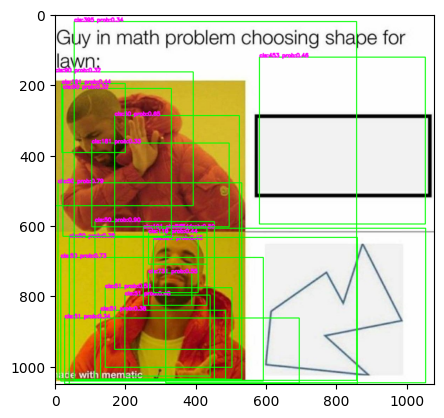


idx  1
label  tensor([1, 1, 0, 0])
['а', '##н', '##н', '##н', '##н', 'о', '##м', '##g', 'something', 'touched', 'me']


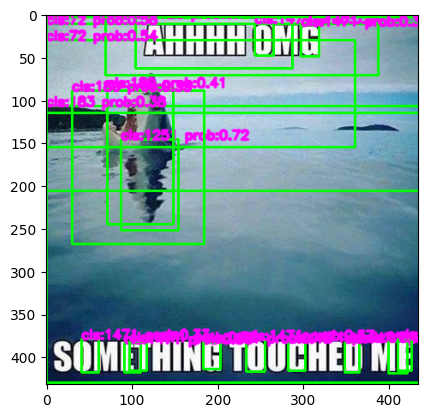


idx  2
label  tensor([1, 0, 0, 0])
['when', 'you', 'accidentally', 'touch', 'your', 'sense', 'of', 'humor']


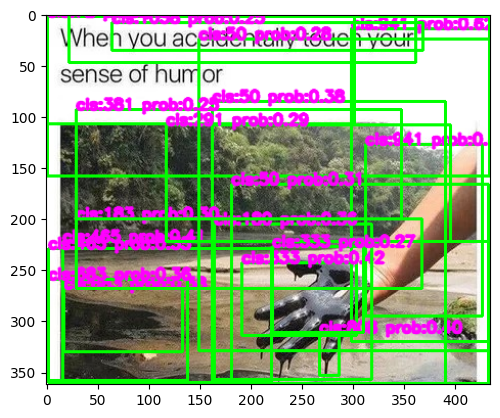


idx  3
label  tensor([1, 1, 0, 0])
['me', 'when', 'i', 'get', 'me', 'explaining', 'why', 'angry', 'i', 'got', 'angry']


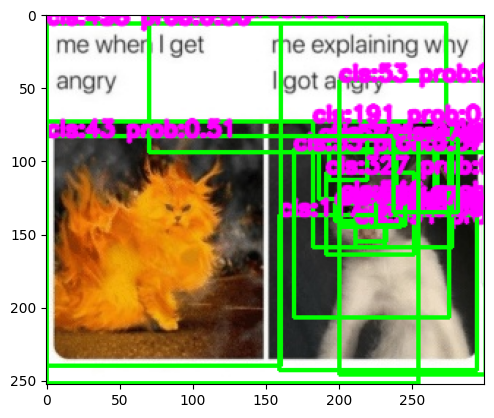


idx  4
label  tensor([1, 0, 0, 0])
['me', 'pretending', 'im', 'listening', 'but', 'im', 'actually', 'thinking', 'about', 'me', '##mes', 'i', '##g']


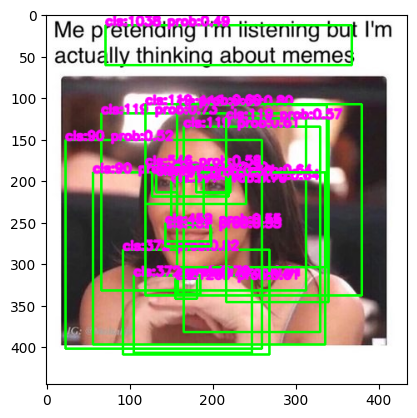


idx  5
label  tensor([0, 0, 0, 0])
['gordon', 'ramsay', 'cannot', 'locate', 'the', 'lamb', 'sauce', 'lamb', 'sauce', 'lo', '##cat', 'ed']


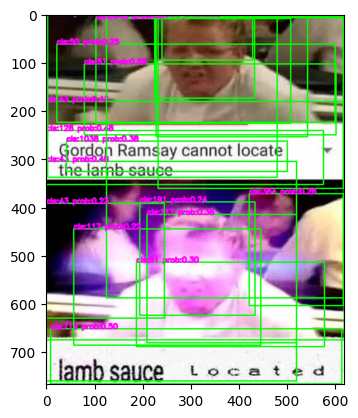


idx  6
label  tensor([1, 0, 0, 0])
['me', 'trying', 'to', 'have', 'a', 'shower', 'wan', '##k', 'everyone', 'else', 'in', 'the', 'gas', 'chamber']


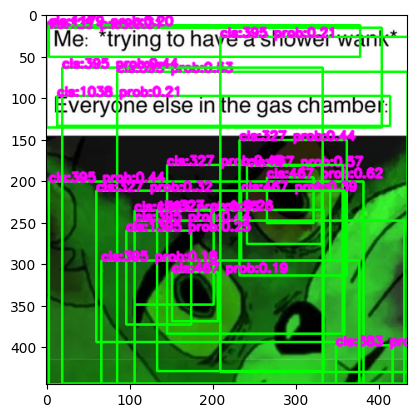


idx  7
label  tensor([1, 0, 0, 0])
['you', 'got', 'caught', 'killing', 'on', 'cam', '##s', 'pan', '##ik', 'your', '##e', 'not', 'playing', 'among', 'us', 'ka', '##lm', 'your', '##e', 'not', 'playing', 'among', 'us', 'no', 'wit', '##nes', '##is', 'i', 'didn', '##t', 'know', 'what', 'to', 'put', 'here']


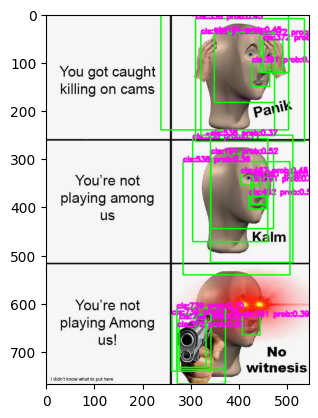

In [16]:
val_img_root_path = '../data/Memotion2.0/images/val_images/'

visual_batch(val_img_root_path, batch_toks, batch_labels, batch_metadata)